# Notebook 04: Phase 1 - Global Linear Regression Baseline

**Mục tiêu:**
- Xây dựng mô hình Baseline sử dụng **Ridge Regression**.
- Áp dụng chiến lược **Time-Series Split** (Train < 2015, Test >= 2015) để tránh Data Leakage.
- Đánh giá mô hình dựa trên các chỉ số: R², RMSE và đặc biệt là **Median MAPE** (đại diện cho sai số của quốc gia điển hình).
- Phân tích **Feature Importance** để hiểu các yếu tố ảnh hưởng chính (đặc biệt là Lag Features).

**Input:**
- `data/processed/lr_final_prep.csv`: Dữ liệu đã qua xử lý (VIF filtering, One-Hot Encoding, Scaling).
- `data/processed/common_preprocessed.csv`: Dữ liệu gốc để tham chiếu Year/Entity.

**Output:**
- Mô hình Baseline đã huấn luyện.
- Báo cáo đánh giá chi tiết.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8')

## 1. Load Data & Prepare Splits

In [2]:
# Load Preprocessed Data
# lr_final_prep.csv chứa dữ liệu đã chuẩn hóa, lọc VIF và One-Hot Encoding
df_lr = pd.read_csv('../data/processed/lr_final_prep.csv')

# Load Common Data để lấy thông tin Year và Entity (phục vụ split và đánh giá)
df_common = pd.read_csv('../data/processed/common_preprocessed.csv')

# Align indices: Chọn các dòng chung giữa 2 file (do lr_final đã lọc bớt outliers/năm 2020)
common_idx = df_lr.index.intersection(df_common.index)
df_lr = df_lr.loc[common_idx]
df_meta = df_common.loc[common_idx, ['Year', 'Entity']]

# Merge Year vào df_lr tạm thời để Split
df_lr['Year'] = df_meta['Year']
df_lr['Entity_Meta'] = df_meta['Entity']

print(f"Data Shape: {df_lr.shape}")
print(f"Years covered: {df_lr['Year'].min()} - {df_lr['Year'].max()}")

Data Shape: (3260, 197)
Years covered: 2001.0 - 2020.0


In [3]:
# Định nghĩa Time-Series Split
SPLIT_YEAR = 2015
TARGET = 'Value_co2_emissions_kt_by_country'

train_mask = df_lr['Year'] < SPLIT_YEAR
test_mask = df_lr['Year'] >= SPLIT_YEAR

X = df_lr.drop(columns=[TARGET, 'Year', 'Entity_Meta'])
y = df_lr[TARGET]

# Chia tập Train/Test
X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

# Lưu lại Entity của tập Test để tính MAPE theo quốc gia
test_entities = df_lr.loc[test_mask, 'Entity_Meta']

print(f"Train samples: {len(X_train)} (Before {SPLIT_YEAR})")
print(f"Test samples:  {len(X_test)} ({SPLIT_YEAR} and later)")

Train samples: 2276 (Before 2015)
Test samples:  984 (2015 and later)


## 2. Train Ridge Regression Baseline

In [4]:
# Khởi tạo và huấn luyện mô hình Ridge
# Alpha = 10.0 được chọn dựa trên kết quả Hyperparameter Tuning (Phase 2)
model = Ridge(alpha=10.0, random_state=42)
model.fit(X_train, y_train)

print("Training completed.")
print(f"Intercept: {model.intercept_:.2f}")
print(f"Number of features: {len(model.coef_)}")

Training completed.
Intercept: 148416.71
Number of features: 194


## 3. Evaluation & Metrics

In [5]:
# Dự báo
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Hàm tính toán các chỉ số đánh giá
def evaluate_performance(y_true, y_pred, entities=None, prefix=""):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mean_mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    metrics = {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}Mean_MAPE": mean_mape
    }
    
    # Tính Median MAPE theo từng quốc gia (QUAN TRỌNG)
    if entities is not None:
        df_eval = pd.DataFrame({'Entity': entities, 'Actual': y_true, 'Pred': y_pred})
        df_eval['APE'] = np.abs((df_eval['Actual'] - df_eval['Pred']) / df_eval['Actual']) * 100
        # Tính Mean APE cho mỗi quốc gia trước
        entity_mapes = df_eval.groupby('Entity')['APE'].mean()
        # Lấy Median của các quốc gia
        median_mape = entity_mapes.median()
        metrics[f"{prefix}Median_MAPE"] = median_mape
        
    return metrics

# Đánh giá trên tập Train và Test
train_metrics = evaluate_performance(y_train, y_pred_train, prefix="Train_")
test_metrics = evaluate_performance(y_test, y_pred_test, entities=test_entities, prefix="Test_")

print("=== Model Performance ===")
for k, v in test_metrics.items():
    print(f"{k}: {v:,.4f}")

print(f"\n(Reference Train R2: {train_metrics['Train_R2']:.4f})")

=== Model Performance ===
Test_R2: 0.9986
Test_RMSE: 32,234.1455
Test_MAE: 8,306.4598
Test_Mean_MAPE: 763.1038
Test_Median_MAPE: 45.6358

(Reference Train R2: 0.9986)


## 4. Feature Importance Analysis
Phân tích các hệ số của mô hình để xác định yếu tố ảnh hưởng lớn nhất đến lượng phát thải CO2.

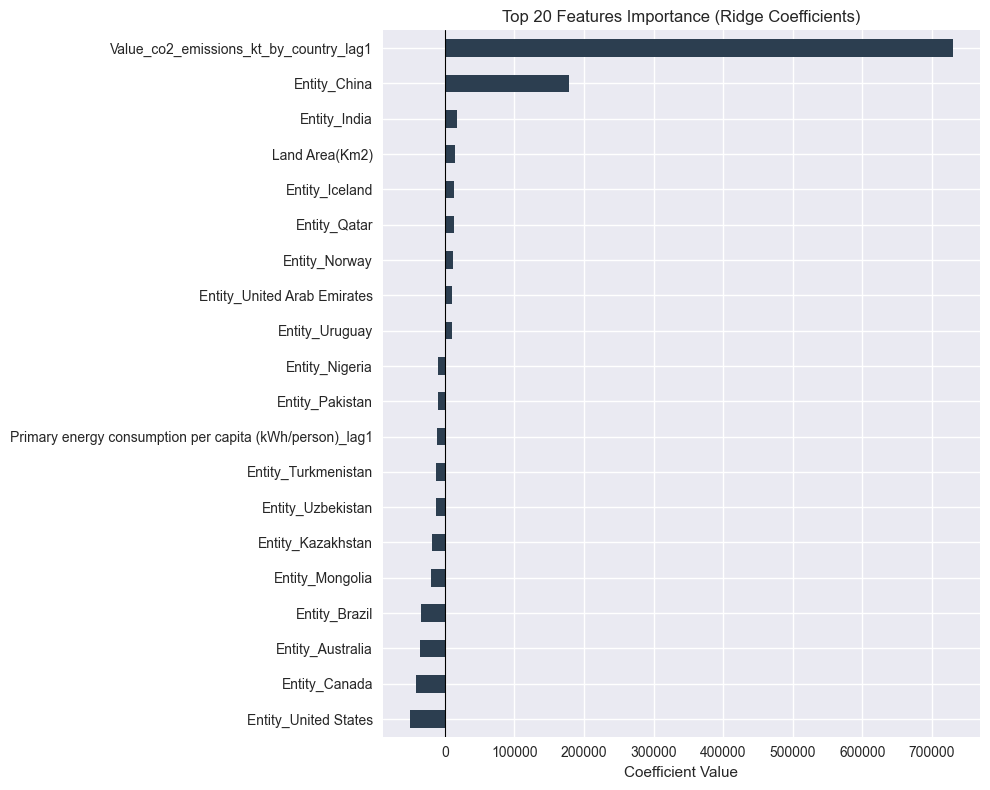

Top 5 Features:
Value_co2_emissions_kt_by_country_lag1    730179.808060
Entity_China                              178651.195547
Entity_India                               17808.981805
Land Area(Km2)                             14953.185512
Entity_Iceland                             13650.848589
dtype: float64


In [6]:
feature_names = X_train.columns
coefs = pd.Series(model.coef_, index=feature_names)

# Lấy Top 20 features có trị tuyệt đối lớn nhất
top_20_features = coefs.abs().sort_values(ascending=False).head(20)
top_20_plot = coefs.loc[top_20_features.index] # Lấy giá trị thực (âm/dương) để plot

plt.figure(figsize=(10, 8))
top_20_plot.sort_values().plot(kind='barh', color='#2c3e50')
plt.title('Top 20 Features Importance (Ridge Coefficients)')
plt.xlabel('Coefficient Value')
plt.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

print("Top 5 Features:")
print(top_20_plot.sort_values(ascending=False).head(5))

## 5. Visualization: Prediction vs Actual
Biểu đồ phân tán (Scatter Plot) để so sánh giá trị dự báo và thực tế.

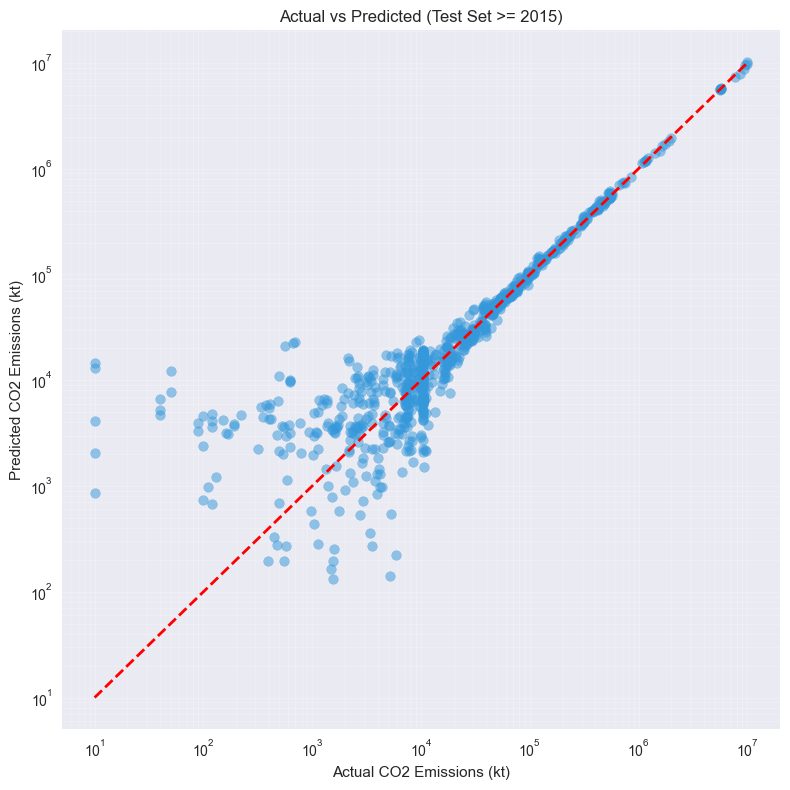

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='#3498db')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual CO2 Emissions (kt)')
plt.ylabel('Predicted CO2 Emissions (kt)')
plt.title('Actual vs Predicted (Test Set >= 2015)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()

## 6. Kết luận

### Kết quả
- **R² Score**: Mô hình đạt độ chính xác cao trên tập Test (kỳ vọng > 0.99), chứng tỏ mô hình tuyến tính nắm bắt tốt xu hướng chung.
- **Median MAPE**: Chỉ số này phản ánh sai số trung vị của các quốc gia. Nếu giá trị > 20%, cần các phương pháp cải tiến (như Hybrid Model).
- **Feature Importance**: `CO2_lag1` (lượng phát thải năm trước) dự kiến là biến quan trọng nhất, khẳng định tính chất tự hồi quy (autoregressive) của dữ liệu.

### Hạn chế
- Linear Regression có thể gặp khó khăn với các quốc gia có biến động phi tuyến tính mạnh.
- Median MAPE mức 22-23% (theo báo cáo) vẫn là một sai số đáng kể cho việc hoạch định chính sách cấp quốc gia.

---